In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.cdf import get_cdf, quantile_regression, get_mean_from_nf, compute_marginal
from NCP.nn.losses import CMELoss
from NCP.metrics import smooth_cdf
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from scipy.stats import laplace, cauchy, bernoulli, pareto
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from sklearn.metrics import mean_squared_error

import normflows as nf

from NCP.nn.nf_module import NFModule

from NCP.examples.tools.plot_utils import setup_plots, plot_expectation
from NCP.examples.tools.data_gen import gen_additive_noise_data
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

NEXP=10

# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


device = 'cuda' if torch.cuda.is_available() else 'cpu'

symatrised pareto distribution

# Laplace noise

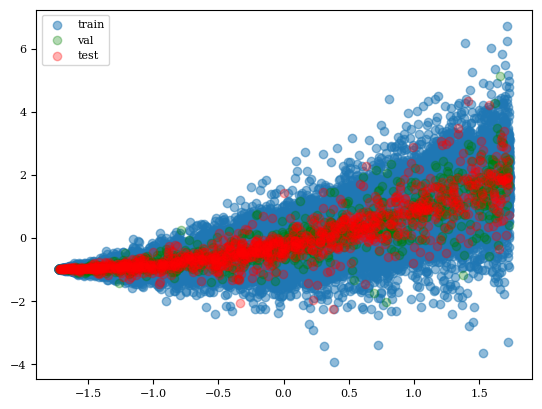

In [9]:
laplace_noise = lambda x : laplace.rvs(loc=0, scale=x)
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_additive_noise_data(laplace_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)
X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)
train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)
#y discretisation for computing cdf
spread = np.max(Y_train) - np.min(Y_train)
p1, p99 = np.min(Y_train), np.max(Y_train)
y_discr, step = np.linspace(p1-0.1*spread, p99+0.1*spread, num=5000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))


plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [ ]:
best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 2e-2
    epochs = int(5e3)
    output_shape = 100

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size': 128,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, 
                      U_operator_kwargs=MLP_kwargs_U, 
                      V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[early_stop, checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

In [ ]:
best_models_nf = {}

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    # Define list of flows (2 flows to emulate our two MLP approach, each with more capacity than our MLPs)
    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units, 
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e3),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

In [ ]:
# plots with quantiles for one model

pred_test = best_models[0].conditional_expectation(X_test, Y_train, postprocess='whitening').reshape(-1, 1)
nf_pred = np.zeros(X_test.shape[0])
nf_quantiles = np.zeros((X_test.shape[0], 2))
pred_quantiles = np.zeros((X_test.shape[0], 2))
for i, xi in enumerate(X_test):
    nf_pred[i] = get_mean_from_nf(best_models_nf[0], torch.Tensor([xi]), 1000)
    nf_quantiles[i] = quantile_regression(best_models_nf[0], torch.Tensor([xi]), y_discr_torch, alpha = 0.01, postprocess='whitening', marginal=marginal, model_type='NF')
    pred_quantiles[i] = quantile_regression(best_models[0], torch.Tensor([xi]), y_discr_torch, alpha = 0.01, postprocess='whitening', marginal=marginal, model_type='NCP')

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()

Xs = xscaler.inverse_transform(X_test)
sorted = np.argsort(Xs.flatten())
axes[0].scatter(Xs, 
                yscaler.inverse_transform(Y_test), 
                color='r', alpha=0.1)
axes[0].plot(Xs.flatten()[sorted], 
            yscaler.inverse_transform(pred_test).flatten()[sorted], 'b', alpha=0.5)
axes[0].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[0].legend(['data points', 'predicted expectation', 'true expectation'])
axes[0].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_test)), 4)})')

axes[1].scatter(Xs, 
                yscaler.inverse_transform(Y_test), 
                color='r', alpha=0.1)
axes[1].plot(Xs.flatten()[sorted], 
            yscaler.inverse_transform(nf_pred).flatten()[sorted], 'b', alpha=0.5)
axes[1].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[1].legend(['data points', 'predicted expectation', 'true expectation'])
axes[1].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(nf_pred)), 4)})')

result for x= 0
- KL: 2.025768269213933
- Hellinger: 1.1103584393296364
result for x= 1
- KL: 0.7714035768814906
- Hellinger: 0.3207626736991175
result for x= 3
- KL: 0.6069520203976047
- Hellinger: 0.23377870048159052
result for x= 4.5
- KL: 0.6047253500732852
- Hellinger: 0.2287794835559116


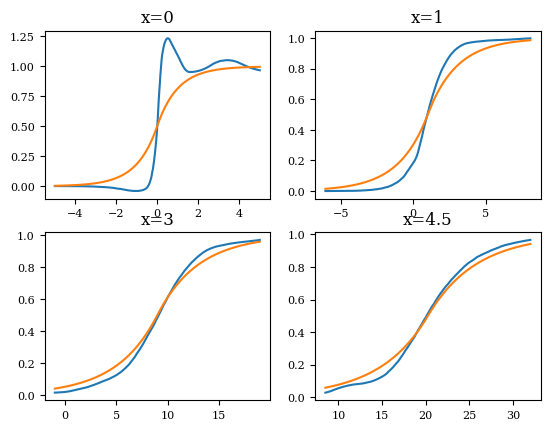

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    cdf_ours = np.zeros()

    for i in range(NEXP):

        x_scaled = torch.Tensor(xscaler.transform([[xi]]))
        fys, cdf_pred = get_cdf(laplace_reg, x_scaled, postprocess='whitening')
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_cdf = laplace.cdf(fys, loc=xi**2, scale=1+xi)

        # normalising the plots for readability:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

In [ ]:
p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):
    x_scaled = torch.Tensor(xscaler.transform([x]))

    our_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    nf_cdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='whitening')
        our_cdfs[exp] = smooth_cdf(ys, cdf_pred_center)

        fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

        nf_cdfs[exp] = get_cdf_from_nf(best_models_nf[exp], x_scaled, y_discr_torch)
    # normalising the plots for readability:
    loc = xi**2
    scale = np.sqrt(1+np.abs(xi))
    plt_interv = [loc - 5*scale, loc+5*scale]
    true_cdf = laplace.cdf(fys, loc=xi**2, scale=1+xi)

    #plot all overlapping with alpha 0.2 + mean bolded

    axes[i].plot(fys, our_cdfs.mean(axis=0), '-ob', label='ours (with whitening)', markevery=40, markersize=5)
    for exp in range(NEXP):
        axes[i].plot(fys, our_cdfs[exp], '-b', alpha=0.2)

    axes[i].plot(fys, nf_cdfs.mean(axis=0), '->y', label='NF',markevery=40, markersize=5)
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_cdfs[exp], '-y', alpha=0.2)

    axes[i].plot(fys, true_cdf, 'r', label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/smooth_cdf_5.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Cauchy noise

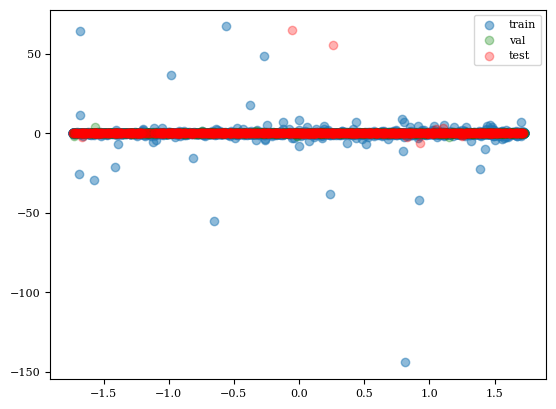

In [15]:
cauchy_noise = lambda x : cauchy.rvs(loc=0, scale=1+x)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(cauchy_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -39.93330001831055: 100%|██████████| 50000/50000 [25:44<00:00, 32.36it/s] 


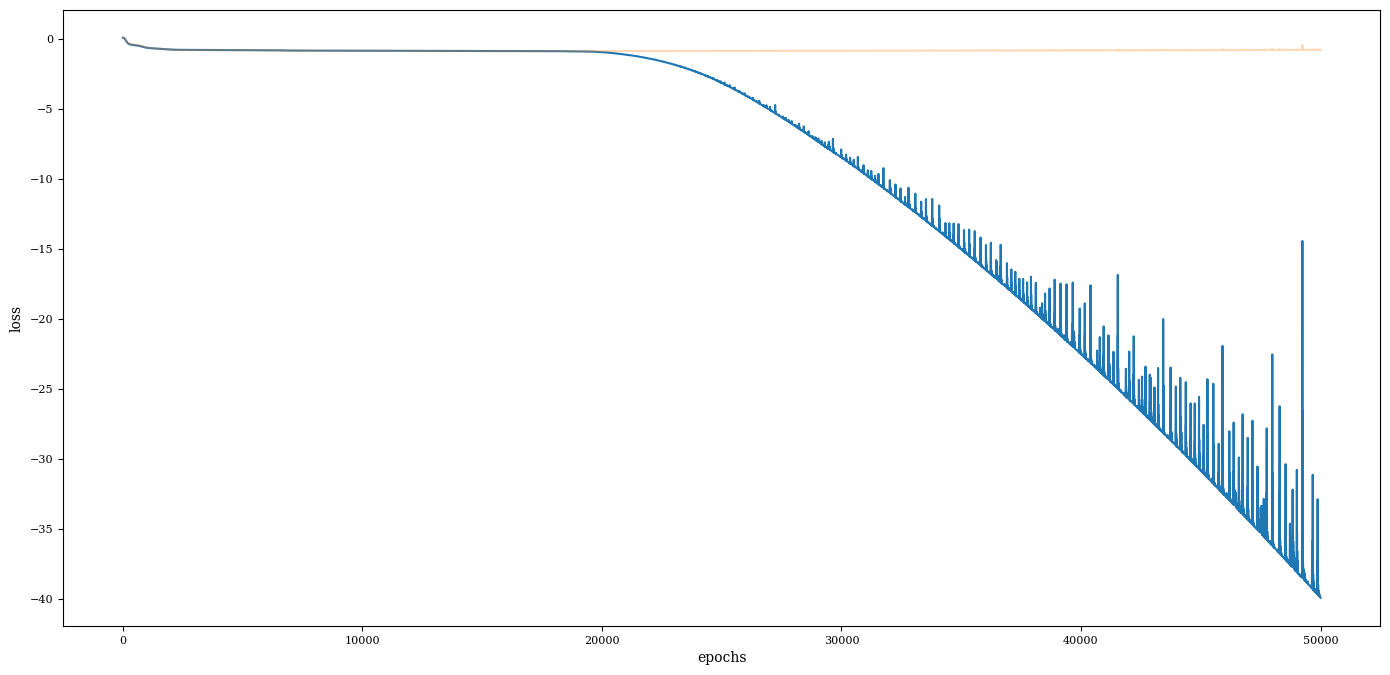

In [16]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

cauchy_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    cauchy_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

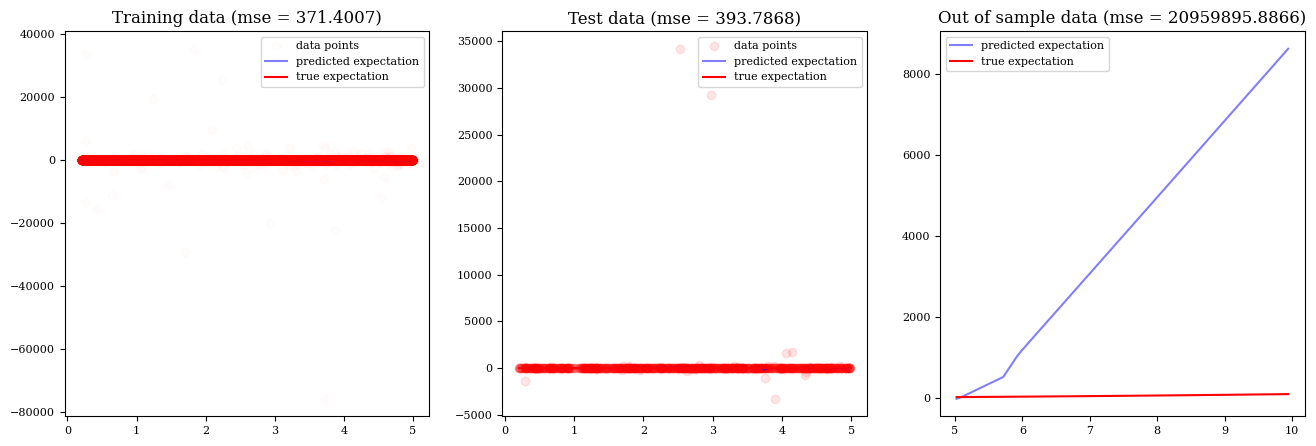

In [17]:
plot_expectation(cauchy_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 0.6339397089841504
- Hellinger: 0.2580952818335685
result for x= 1
- KL: 0.46296147998968123
- Hellinger: 0.1868691416435469
result for x= 3
- KL: 0.4386493044392724
- Hellinger: 0.17600921378623074
result for x= 4.5
- KL: 0.3846038270424623
- Hellinger: 0.165559679348731


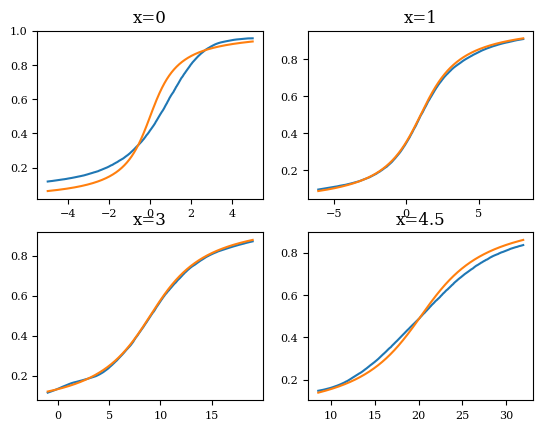

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(cauchy_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = cauchy.cdf(fys, loc=xi**2, scale=1+xi)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')

plt.show()

# Pareto noise

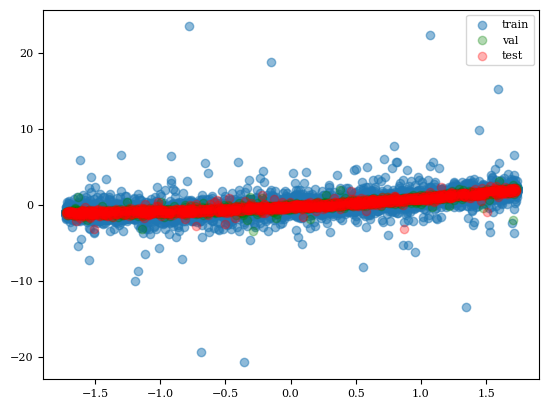

In [31]:
def sym_pareto_cdf(x, scale):
    x_neg = (x<0)
    x_pos = (x>0)
    cdf_x_pos = pareto.cdf(x, scale)
    cdf_x_neg = 1-pareto.cdf(-x, scale)
    return 0.5* cdf_x_neg *  x_neg + (0.5+ 0.5 * cdf_x_pos) *  x_pos

pareto_noise = lambda x : pareto.rvs(2)* (2*bernoulli.rvs(0.5)-1)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(pareto_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -4.368854522705078: 100%|██████████| 50000/50000 [30:07<00:00, 27.67it/s] 


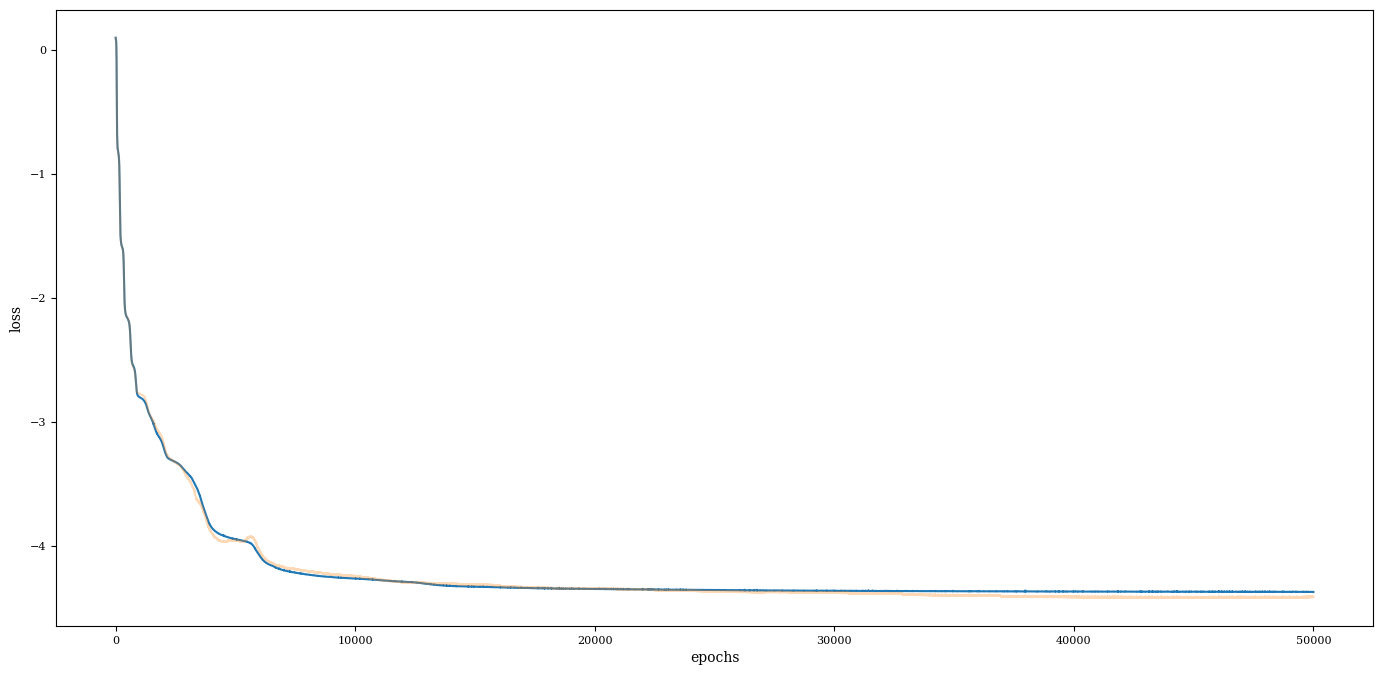

In [28]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

pareto_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    pareto_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

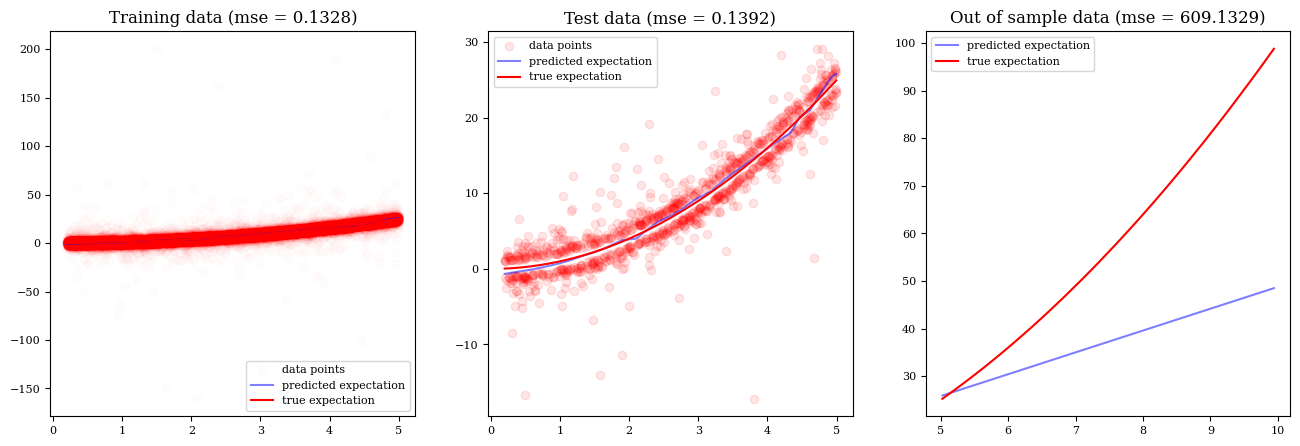

In [29]:
plot_expectation(pareto_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: inf
- Hellinger: 0.48825243600600726


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 1
- KL: inf
- Hellinger: 0.4568796621346792


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 3
- KL: inf
- Hellinger: 0.6198143242999391


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 4.5
- KL: inf
- Hellinger: 0.7076717248550572


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


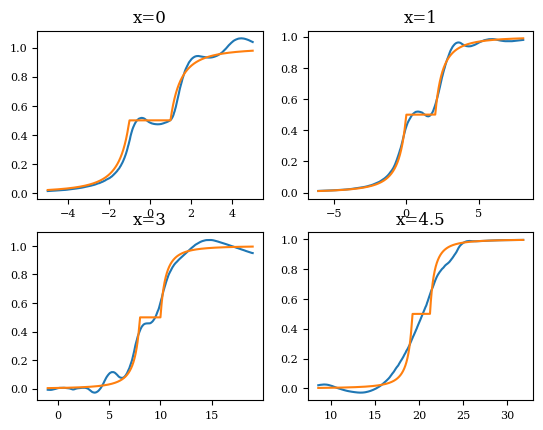

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(pareto_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = sym_pareto_cdf(fys-xi**2, 2)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()